In [ ]:
!mamba install -c bioconda p

In [3]:
import numpy as np
from Bio import motifs
import pandas as pd
from pyjaspar import jaspardb

### Motif searching

In [6]:
jdb_obj = jaspardb()
print(jdb_obj.release)

JASPAR2022


In [11]:
cnc = jdb_obj.fetch_motif_by_id('MA0530.1')
print(cnc)

TF name	cnc::maf-S
Matrix ID	MA0530.1
Collection	CORE
TF class	['Basic leucine zipper factors (bZIP)', 'Basic leucine zipper factors (bZIP)']
TF family	['Jun-related', 'Maf-related']
Species	7227
Taxonomic group	insects
Accession	['P20482', 'Q4QPP9']
Data type used	ChIP-chip
Medline	10952900
Matrix:
        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14
A: 142.00 340.00   0.00   0.00 407.00   0.00  80.00  78.00 136.00  24.00   0.00 368.00 133.00 221.00 214.00
C: 113.00  20.00   0.00   0.00  46.00 292.00   0.00 215.00  33.00   0.00 474.00   0.00 128.00  63.00  12.00
G: 159.00 114.00   0.00 474.00  21.00  80.00 169.00  90.00 163.00 422.00   0.00 106.00  99.00   0.00   0.00
T:  60.00   0.00 474.00   0.00   0.00 102.00 225.00  91.00 142.00  28.00   0.00   0.00 114.00 190.00 248.00





In [12]:
pwm = cnc.counts.normalize(pseudocounts=0.5)
print(pwm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14
A:   0.30   0.72   0.00   0.00   0.86   0.00   0.17   0.16   0.29   0.05   0.00   0.77   0.28   0.47   0.45
C:   0.24   0.04   0.00   0.00   0.10   0.61   0.00   0.45   0.07   0.00   1.00   0.00   0.27   0.13   0.03
G:   0.34   0.24   0.00   1.00   0.05   0.17   0.36   0.19   0.34   0.89   0.00   0.22   0.21   0.00   0.00
T:   0.13   0.00   1.00   0.00   0.00   0.22   0.47   0.19   0.30   0.06   0.00   0.00   0.24   0.40   0.52



### Searching a sequence

In [27]:
from Bio.Seq import Seq

import malariagen_data
ag3 = malariagen_data.Ag3()

In [15]:
contig = '2L'
start= 28_545_000
end = 28_550_000

region = f'{contig}:{start}-{end}'
print(region)

2L:28545000-28550000


In [32]:
# Load sequence for a region
my_seq = ag3.genome_sequence(region=region).compute()
my_seq = ''.join(my_seq.astype(str))

In [33]:
my_seq=Seq(my_seq)
len(my_seq)

5001

#### Search using PSSM score

In [50]:
pssm = pwm.log_odds()
print(pssm)

        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14
A:   0.26   1.52  -7.89  -7.89   1.78  -7.89  -0.56  -0.60   0.20  -2.28  -7.89   1.63   0.17   0.90   0.85
C:  -0.07  -2.54  -7.89  -7.89  -1.36   1.30  -7.89   0.86  -1.83  -7.89   2.00  -7.89   0.11  -0.91  -3.25
G:   0.42  -0.06  -7.89   2.00  -2.47  -0.56   0.51  -0.39   0.46   1.83  -7.89  -0.16  -0.26  -7.89  -7.89
T:  -0.98  -7.89   2.00  -7.89  -7.89  -0.22   0.92  -0.38   0.26  -2.06  -7.89  -7.89  -0.06   0.68   1.06



In [53]:
for position, score in pssm.search(my_seq, threshold=3.0):
    print("Position %d: score = %5.3f" % (position, score))
    print(my_seq[position:position+len(cnc)])

Position 973: score = 6.199
AGTGATTGTACGTCT
Position -3395: score = 3.463
TGATGCTTAATAATC
Position 2335: score = 6.644
CATGAGAACACACTA
Position -2646: score = 8.427
TATCGCTCCACCATG
Position 2366: score = 10.983
CATGATTAGACACAA
Position 2840: score = 8.144
TGTGAGACCGCACCA
Position 3022: score = 6.276
AAAGAGGCGGCAATT
Position -1560: score = 7.787
TACTGCACAACCACA
Position -1087: score = 7.489
TGTTGTTTTATCATG


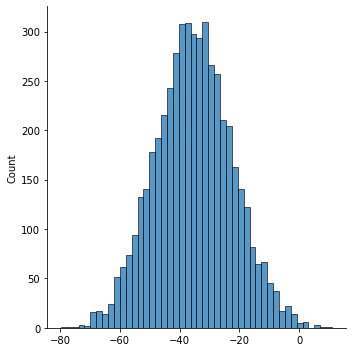

In [57]:
import seaborn as sns
sns.displot(pssm.calculate(my_seq))

In [58]:
rpssm = pssm.reverse_complement()
rpssm.calculate(my_seq)

array([-14.5947075, -26.071215 , -44.23629  , ..., -65.800735 ,
       -51.118576 , -27.172113 ], dtype=float32)

#### Selecting a score threshold

In [60]:
distribution = pssm.distribution(precision=10**4)

In [61]:
threshold = distribution.threshold_fpr(0.01)
print("%5.3f" % threshold)

-5.616


In [62]:
threshold = distribution.threshold_fnr(0.1)
print("%5.3f" % threshold)

9.726


In [63]:
threshold = distribution.threshold_balanced(1000)
print("%5.3f" % threshold)

9.952


#### Run for each gene in the cluster, and look for SNPs

In [69]:
import allel
gff = allel.gff3_to_dataframe("/home/sanj/ag1000g/data/reference/gff/An.gambiae-PEST-BASEFEATURES_agamP4.12.gff3", attributes=['Parent', 'ID'])
gff = gff.query("seqid == @contig")

In [72]:
gff = gff.query("start > 28_520_000 & end < 28_560_000")

In [76]:
genegff = gff.query("type == 'gene'")
fiveprimegff = gff.query("type == 'five_prime_UTR'")
threeprimegff = gff.query("type == 'three_prime_UTR'")

In [80]:
geneIDs = genegff['ID'].to_list()

In [92]:
genegff

,seqid,source,type,start,end,score,strand,phase,Parent,ID
24759,2L,VectorBase,gene,28524225,28526317,-1,+,-1,.,AGAP006222
24773,2L,VectorBase,gene,28526558,28528641,-1,+,-1,.,AGAP006223
24787,2L,VectorBase,gene,28528758,28533199,-1,+,-1,.,AGAP006224
24803,2L,VectorBase,gene,28534732,28539416,-1,+,-1,.,AGAP006225
24819,2L,VectorBase,gene,28540651,28545294,-1,+,-1,.,AGAP006226
24833,2L,VectorBase,gene,28545396,28547938,-1,-,-1,.,AGAP006227
24852,2L,VectorBase,gene,28548433,28550748,-1,+,-1,.,AGAP006228
24864,2L,VectorBase,gene,28550814,28552032,-1,+,-1,.,AGAP006229


In [170]:
def getSeq(gff, gene, contig='2L', genes=True, bases=200):
    if genes == True:
        my_start, my_end = gff.query("ID == @gene").loc[:, ('start', 'end')].values[0]
        if bases < 0:
            my_region = f'{contig}:{my_end}-{my_end+np.abs(bases)}'
        else:
            my_region = f'{contig}:{my_start-bases}-{my_start}'
    else:
        df = gff.query(f"Parent == '{gene}-RA'")
        if len(df) < 1: 
            return(None)
        my_start, my_end = df.loc[:, ('start', 'end')].values[0]
        my_region = f'{contig}:{my_start}-{my_end}'
    
    print(my_region)
    my_seq = ag3.genome_sequence(region=my_region).compute()
    my_seq = ''.join(my_seq.astype(str))
    return(my_seq)

In [173]:
for gene in geneIDs:
    print("\n")
    print(gene)    
    
    print("five_prime")
    myseq5 = getSeq(fiveprimegff, gene, genes=False)
    for position, score in pssm.search(myseq5, threshold=3):
        print("Position %d: score = %5.3f" % (position, score))
        print(myseq5[position:position+len(cnc)])
    
    print("three_prime")
    myseq3 = getSeq(threeprimegff, gene, genes=False)
    if myseq3 == None: continue
    for position, score in pssm.search(myseq3, threshold=3):
        print("Position %d: score = %5.3f" % (position, score))
        print(myseq3[position:position+len(cnc)])
      
    print("upstream")    
    mysequpstream = getSeq(genegff, gene, genes=True, bases=200)
    if mysequpstream == None: continue
    for position, score in pssm.search(mysequpstream, threshold=3):
        print("Position %d: score = %5.3f" % (position, score))
        print(mysequpstream[position:position+len(cnc)])
    
    print("downstream")
    myseqdownstream = getSeq(genegff, gene, genes=True, bases=-200)
    if myseqdownstream == None: continue
    for position, score in pssm.search(myseqdownstream, threshold=3):
        print("Position %d: score = %5.3f" % (position, score))
        print(myseqdownstream[position:position+len(cnc)])      
        
        



AGAP006222
five_prime
2L:28524225-28524283
three_prime
2L:28526142-28526317
upstream
2L:28524025-28524225
Position 131: score = 7.554
CATTACGCAGCAAAA
downstream
2L:28526317-28526517
Position -23: score = 6.466
ATTCGCTGCGTAATC
Position 182: score = 3.514
GCTGCGTAATCATTA


AGAP006223
five_prime
2L:28526558-28526653
three_prime
2L:28528492-28528641
upstream
2L:28526358-28526558
Position -64: score = 6.466
ATTCGCTGCGTAATC
Position 141: score = 3.514
GCTGCGTAATCATTA
downstream
2L:28528641-28528841


AGAP006224
five_prime
2L:28528758-28528881
three_prime
2L:28533014-28533199
upstream
2L:28528558-28528758
downstream
2L:28533199-28533399


AGAP006225
five_prime
2L:28534732-28535005
Position 104: score = 4.639
AGTGCTACTACGATT
three_prime
2L:28539261-28539416
upstream
2L:28534532-28534732
Position -150: score = 5.379
TGACGCACACGCACA
Position 114: score = 14.194
GGTGACAGAGCACAT
downstream
2L:28539416-28539616


AGAP006226
five_prime
2L:28540651-28540893
three_prime


AGAP006227
five_prime
2L:28